<a href="https://colab.research.google.com/github/ckj18/BigDataSecurity/blob/main/TeamProject_MalwareDetection_ipynb_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 드라이브 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd '/content/drive/Shareddrives/BigDataSecurity'

/content/drive/Shareddrives/BigDataSecurity


In [ ]:
ls

Dataset/  Dataset.zip  init_params.pt  malware/


In [ ]:
# Dataset.zip 압축 해제
# !unzip -qq ./Dataset.zip -d ./Dataset

## 모듈 불러오기

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import cv2
import torch.utils.data
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import _LRScheduler
from torchsummary import summary
from tqdm import tqdm
from skimage.feature import hog
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils, datasets
from PIL import ImageFile
from PIL import Image
from collections import namedtuple

ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

## 데이터셋 불러오기


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, malware_list, transform=None):
        self.root = root
        self.malware_list = malware_list
        self.transform = transform
        self.data = []
        self.targets = []
        self.folder_to_label = {}  # 폴더명과 클래스 레이블 매핑을 위한 딕셔너리
        self.malware_type = []
        self.file_paths = []  # 파일 경로 저장을 위한 리스트

        for idx, folder_name in enumerate(os.listdir(root)):
            folder_path = os.path.join(root, folder_name)

            if folder_name in malware_list:
              if folder_name == 'Benign':
                self.folder_to_label[folder_name] = 0
              else:
                self.folder_to_label[folder_name] = 1  # 폴더명에 대한 레이블 변환 결과 저장

              for image_name in os.listdir(folder_path):
                  if image_name.endswith('.png'):  # 이미지 파일 확장자 지정
                      image_path = os.path.join(folder_path, image_name)
                      self.data.append(image_path)

                      if folder_name == 'Benign':
                          self.malware_type.append('Benign')
                          self.targets.append('Benign')
                      else:
                          self.malware_type.append(folder_name)
                          self.targets.append(folder_name)

                      self.file_paths.append(image_path)  # 파일 경로 저장

    def __getitem__(self, index):
        image_path = self.file_paths[index]  # 저장한 파일 경로 사용
        target = self.targets[index]
        image = Image.open(image_path)
        malware_type = self.malware_type[index]

        if self.transform is not None:
            image = self.transform(image)

        target = self.folder_to_label[target]  # 폴더명에 대한 레이블 변환 결과 가져오기
        return image, target, image_path, malware_type

    def __len__(self):
        return len(self.data)


In [ ]:
# 이미지의 RGB 채널별 통계량 확인 함수
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _, _, _ in dataset])
    print(f'shape: {imgs.shape}')

    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

In [ ]:
malware_list = ['Benign', 'Adposhel', 'Allaple', 'Amonetize', 'Autorun', 'BrowseFox', 'Dinwod', 'InstallCore', 'MultiPlug', 'VBA', 'Vilsel']

In [ ]:
train_path = './Dataset/Train'
test_path = './Dataset/Test'

In [ ]:
train_path2 = './malware/train'
test_path2 = './malware/val'

In [ ]:
train_data = CustomDataset(root = train_path2, malware_list=malware_list,
                                  transform = image_transforms['train'])
test_dataset = CustomDataset(root = test_path2, malware_list=malware_list,
                                  transform = image_transforms['test'])

In [ ]:
train_data = CustomDataset(root = train_path, malware_list=malware_list,
                                  transform = image_transforms['train'])
test_dataset = CustomDataset(root = test_path, malware_list=malware_list,
                                  transform = image_transforms['test'])

In [ ]:
# print_stats(train_data)
# shape: (2960, 3, 224, 224)
# min: (0.0, 0.0, 0.0)
# max: (1.0, 1.0, 1.0)
# mean: (0.37342563, 0.3735171, 0.37316877)
# std: (0.06360447, 0.06375149, 0.063765444)

In [ ]:
image_transforms2 = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-20, 20)),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.37342563, 0.3735171, 0.37316877], [0.063604474, 0.06375148, 0.063765444])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.37342563, 0.3735171, 0.37316877], [0.063604474, 0.06375148, 0.063765444])
    ])
}

In [ ]:
train_data = CustomDataset(root = train_path, malware_list=malware_list,
                                  transform = image_transforms2['train'])
test_dataset = CustomDataset(root = test_path, malware_list=malware_list,
                                  transform = image_transforms2['test'])

In [ ]:
len(train_data)

3844

In [ ]:
len(test_dataset)

2928

In [ ]:
test_data2, combine_data = torch.utils.data.random_split(test_dataset, [1354, 2928-1354])

test_scale = int(len(test_data2) / 2)

In [ ]:
def TestLoader(Dataset):
  torch.manual_seed(0)
  valid_data, test_data = torch.utils.data.random_split(Dataset, [test_scale, test_scale])

  valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=False) # make test loader
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False) # make test loader

  return valid_loader, test_loader, valid_data, test_data

In [ ]:
train_dataset = ConcatDataset([train_data, combine_data])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True) # make train loader
valid_loader, test_loader, valid_data, test_data = TestLoader(test_data2) # make valid & test loader

In [ ]:
def show_datasize():
  print(f'Number of training examples: {len(train_dataset)}')
  print(f'Number of validation examples: {int(len(valid_data))}')
  print(f'Number of testing examples: {int(len(test_data))}')

show_datasize()

Number of training examples: 5418
Number of validation examples: 677
Number of testing examples: 677


In [ ]:
classes = train_data.folder_to_label
classes

{'VBA': 1,
 'Vilsel': 1,
 'MultiPlug': 1,
 'Benign': 0,
 'InstallCore': 1,
 'Autorun': 1,
 'Amonetize': 1,
 'Dinwod': 1,
 'Allaple': 1,
 'BrowseFox': 1,
 'Adposhel': 1}

In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, _, _ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()

labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

KeyboardInterrupt: ignored

## 전처리

### Laplacian Filtering (Edge 강화) && Bilateral Filtering (노이즈 제거) 적용

In [ ]:
# import os
# import cv2
# import numpy as np

# # Train 폴더 위치
# train_folder = './malware/train/'

# # Bila_Train 폴더 위치
# bila_folder = '/home/Bila_folder1'

# # Laplace_Bila_Train 폴더 위치
# both_folder = '/home/both_folder1'

# # 모든 클래스에 대해 불러옵니다.
# for class_folder in os.walk(train_folder).__next__()[1]:
#     # 클래스 이름을 불러옵니다.
#     class_name = class_folder
#     # 클래스 폴더의 경로를 붙여넣습니다.
#     class_folder_path = os.path.join(train_folder, class_folder)
#     # Bila_Train 폴더에 저장할 경로를 지정하고 생성합니다.
#     bila_class_folder_path = os.path.join(bila_folder, class_folder)
#     # Both_Train 폴더에 저장할 경로를 지정하고 생성합니다.
#     both_class_folder_path = os.path.join(both_folder, class_folder)
#     os.makedirs(both_class_folder_path, exist_ok=True)

#     # 클래스 폴더를 순회하며 Laplacian Filtering과 Bilateral Filtering을 적용한 이미지를 저장합니다.
#     for image_file in os.listdir(class_folder_path):
#         # 파일 경로를 붙여넣습니다.
#         image_file_path = os.path.join(class_folder_path, image_file)

#         # 이미지 파일을 불러옵니다.
#         image = cv2.imread(image_file_path)

#         # 이미지가 제대로 불러와지지 않은 경우 다음 이미지로 넘어갑니다.
#         if image is None:
#             continue

#         # Laplacian Filtering을 적용합니다.
#         lap_image = cv2.Laplacian(image, cv2.CV_8U, ksize=3)

#         # Bilateral Filtering을 적용합니다.
#         bila_image = cv2.bilateralFilter(image, -1, 10, 5)

#         # Laplace_Bila_Train 폴더에 라플라시안 이미지를 저장합니다.
#         lap_image_path = os.path.join(both_class_folder_path, 'lap_' + image_file)
#         cv2.imwrite(lap_image_path, lap_image)

#         # Laplace_Bila_Train 폴더에 Bilateral 이미지를 저장합니다.
#         bila_image_path = os.path.join(both_class_folder_path, 'bila_' + image_file)
#         cv2.imwrite(bila_image_path, bila_image)

#         # 파일 경로를 붙여넣습니다.
#         both_image_path = os.path.join(both_class_folder_path, 'both_' + image_file)

#         # both 이미지가 이미 저장된 경우 lap_image와 bila_image의 기존 이미지를 제거하고 both_image를 저장합니다.
#         if os.path.isfile(both_image_path):
#             os.remove(lap_image_path)
#             os.remove(bila_image_path)

#         # 이미지를 불러와서 Laplacian Filtering과 Bilateral Filtering을 모두 적용합니다.
#         lap_image = cv2.imread(lap_image_path)
#         bila_image = cv2.imread(bila_image_path)

#         # 이미지가 제대로 불러와지지 않은 경우 다음 이미지로 넘어갑니다.
#         if lap_image is None or bila_image is None:
#             continue

#         both_image = cv2.addWeighted(lap_image, 0.5, bila_image, 0.5, 0)

#         # Laplace_Bila_Train 폴더에 Laplacian Filtering과 Bilateral Filtering을 모두 적용한 이미지를 저장합니다.
#         cv2.imwrite(both_image_path, both_image)

In [ ]:
# import os
# import cv2
# import numpy as np

# # Train 폴더 위치
# train_folder = './malware2/train/'

# # Bila_Train 폴더 위치
# bila_folder = '/home/Bila_folder2'

# # Laplace_Bila_Train 폴더 위치
# both_folder = '/home/both_folder2'

# # 모든 클래스에 대해 불러옵니다.
# for class_folder in os.walk(train_folder).__next__()[1]:
#     # 클래스 이름을 불러옵니다.
#     class_name = class_folder
#     # 클래스 폴더의 경로를 붙여넣습니다.
#     class_folder_path = os.path.join(train_folder, class_folder)
#     # Bila_Train 폴더에 저장할 경로를 지정하고 생성합니다.
#     bila_class_folder_path = os.path.join(bila_folder, class_folder)
#     # Both_Train 폴더에 저장할 경로를 지정하고 생성합니다.
#     both_class_folder_path = os.path.join(both_folder, class_folder)
#     os.makedirs(both_class_folder_path, exist_ok=True)

#     # 클래스 폴더를 순회하며 Laplacian Filtering과 Bilateral Filtering을 적용한 이미지를 저장합니다.
#     for image_file in os.listdir(class_folder_path):
#         # 파일 경로를 붙여넣습니다.
#         image_file_path = os.path.join(class_folder_path, image_file)

#         # 이미지 파일을 불러옵니다.
#         image = cv2.imread(image_file_path)

#         # 이미지가 제대로 불러와지지 않은 경우 다음 이미지로 넘어갑니다.
#         if image is None:
#             continue

#         # Laplacian Filtering을 적용합니다.
#         lap_image = cv2.Laplacian(image, cv2.CV_8U, ksize=3)

#         # Bilateral Filtering을 적용합니다.
#         bila_image = cv2.bilateralFilter(image, -1, 10, 5)

#         # Laplace_Bila_Train 폴더에 라플라시안 이미지를 저장합니다.
#         lap_image_path = os.path.join(both_class_folder_path, 'lap_' + image_file)
#         cv2.imwrite(lap_image_path, lap_image)

#         # Laplace_Bila_Train 폴더에 Bilateral 이미지를 저장합니다.
#         bila_image_path = os.path.join(both_class_folder_path, 'bila_' + image_file)
#         cv2.imwrite(bila_image_path, bila_image)

#         # 파일 경로를 붙여넣습니다.
#         both_image_path = os.path.join(both_class_folder_path, 'both_' + image_file)

#         # both 이미지가 이미 저장된 경우 lap_image와 bila_image의 기존 이미지를 제거하고 both_image를 저장합니다.
#         if os.path.isfile(both_image_path):
#             os.remove(lap_image_path)
#             os.remove(bila_image_path)

#         # 이미지를 불러와서 Laplacian Filtering과 Bilateral Filtering을 모두 적용합니다.
#         lap_image = cv2.imread(lap_image_path)
#         bila_image = cv2.imread(bila_image_path)

#         # 이미지가 제대로 불러와지지 않은 경우 다음 이미지로 넘어갑니다.
#         if lap_image is None or bila_image is None:
#             continue

#         both_image = cv2.addWeighted(lap_image, 0.5, bila_image, 0.5, 0)

#         # Laplace_Bila_Train 폴더에 Laplacian Filtering과 Bilateral Filtering을 모두 적용한 이미지를 저장합니다.
#         cv2.imwrite(both_image_path, both_image)

### HOG

In [ ]:
hog_features = []
hog = cv2.HOGDescriptor()

In [ ]:
pip install scikit-image

In [ ]:
import cv2
import numpy as np
from skimage.util import view_as_blocks
from sklearn.preprocessing import StandardScaler

In [ ]:
# Gabor 필터 생성 함수
def create_filters(scales, orientations):
    filters = []
    for scale in range(scales[0], scales[1] + 1):
        for orientation in np.arange(0, np.pi, np.pi / orientations):
            filt_real = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0, ktype=cv2.CV_32F)
            filt_imag = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0.5 * np.pi, ktype=cv2.CV_32F)
            filt = filt_real + filt_imag
            filt /= 2.0 * np.pi * scale * scale
            filters.append(filt)
    return filters

# HOG 디스크립터 계산 함수
def hog_descriptor_single_channel(image, scales=(8, 8), orientations=8, blocks=(4, 4)):    # Gabor 필터 생성
    filters = create_filters(scales, orientations)

    # 이미지 크기와 블록 크기 계산
    height, width = image.shape[:2]
    block_size = height // blocks[0], width // blocks[1]

    padding_size = blocks[0] * block_size[0] - height, blocks[1] * block_size[1] - width

    # 이미지 패딩 (필요한 경우)
    if padding_size != (0, 0):
        image = cv2.copyMakeBorder(image, 0, padding_size[0], 0, padding_size[1], cv2.BORDER_CONSTANT, value=0)

    # 이미지를 블록으로 분할
    block_shape = (block_size[0], block_size[1])
    blocks = view_as_blocks(image, block_shape=(block_size[0], block_size[1])).reshape(-1, *block_size, order='F')

    # 각 블록의 GIST 특성 추출
    features = []
    for block in blocks:
        feats = []
        for scale in filters:
            for filt in scale:
                filtered = cv2.filter2D(block, cv2.CV_64F, filt)
                feats.append(filtered.mean())
        features.append(feats)

    # 전체 GIST 디스크립터로 결합
    return np.concatenate(features)


def hog_descriptor(image, scales=(8, 8), orientations=8, blocks=(4, 4)):
    if len(image.shape) == 3:
    # 각 채널에 대해 GIST 디스크립터 계산
        descriptors = [hog_descriptor_single_channel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scales, orientations, blocks)]            # 전체 GIST 디스크립터로 결합
        return np.concatenate(descriptors)
    else:
    # 단일 채널 이미지의 경우 GIST 디스크립터를 한 번만 계산
        return hog_descriptor_single_channel(image, scales, orientations, blocks)

In [ ]:
# 각 이미지에 맞는 레이블 생성
def load_labels(dir, num_samples):
    y = []
    for subdir in sorted(os.listdir(dir)):
        subdir_path = os.path.join(dir, subdir)
        if os.path.isdir(subdir_path):
            for i, filename in enumerate(sorted(os.listdir(subdir_path))):
                y.append(labels_dict[subdir])
                if len(y) == num_samples:
                    break
        if len(y) == num_samples:
            break
    return np.array(y)

In [ ]:
# 각 악성코드 이미지 폴더에서 350개의 이미지에 대한 gist descriptor를 계산하여 반환
def get_hog_descriptors(train_data):
    descriptors = []
    labels = []
    for i, v in enumerate(train_data):
      _,label,path = v
      # 파일 경로 생성
      # 이미지 로드
      image = cv2.imread(path)
      # 이미지에 대한 GIST 디스크립터 계산
      descriptor = hog_descriptor(image)
      descriptors.append(descriptor)
      labels.append(label)
      if i % 100 == 99:
        print("\tProcessed", i + 1, "images")
    return np.array(descriptors) , np.array(labels)

In [ ]:
descriptors, train_labels = get_hog_descriptors(train_data)
print(len(descriptors))
print('HOG Descriptor Shape:', descriptors.shape)

In [ ]:
pip install scikit-learn xgboost

In [ ]:
# 데이터와 레이블 설정
X = descriptors
hog_features = X

# hog_descriptors 및 레이블 불러오기
X_train = X
X_val , val_label= get_hog_descriptors(add_data)
X_test, test_label = get_hog_descriptors(test_data)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier

In [ ]:
# 레이블 설정
labels_dict = classes

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Linear SVM': LinearSVC(),
    'SMO': SVC(kernel='rbf'), # SMO는 일반적으로 서포트 벡터 머신 (SVM)이 rbf 커널을 사용
    'J48': DecisionTreeClassifier() # J48는 scikit-learn에서 Decision Tree에 해당
}

# 성능 지표
scores = {'accuracy': accuracy_score, 'FPR': confusion_matrix, 'precision': precision_score, 'recall': recall_score, 'f1score': f1_score}

# 각 모델에 대해 교차 검증 및 테스트 세트에서 성능 평가
for model_name, model_instance in models.items():
    print(model_name)
    model_instance.fit(X_train_scaled, train_labels)
    y_pred = model_instance.predict(X_test_scaled)
    for score_name, score_func in scores.items():
        if score_name == 'FPR':
            cm = score_func(test_label, y_pred)
            fp = cm.sum(axis=0) - np.diag(cm)
            tn = cm.sum() - (cm.sum(axis=1) + fp)
            fpr = np.mean(fp / (fp + tn))
            print(score_name, fpr)
        elif score_name == 'accuracy':
            print(score_name, score_func(test_label, y_pred))
        else:
            print(score_name, score_func(test_label, y_pred, average='weighted'))

###GIST

In [ ]:
pip install scikit-image

In [ ]:
import cv2
import numpy as np
from skimage.util import view_as_blocks

In [ ]:
# Gabor 필터 생성 함수
def create_filters(scales, orientations):
    filters = []
    for scale in range(scales[0], scales[1] + 1):
        for orientation in np.arange(0, np.pi, np.pi / orientations):
            filt_real = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0, ktype=cv2.CV_32F)
            filt_imag = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0.5 * np.pi, ktype=cv2.CV_32F)
            filt = filt_real + filt_imag
            filt /= 2.0 * np.pi * scale * scale
            filters.append(filt)
    return filters

# GIST 디스크립터 계산 함수
def gist_descriptor_single_channel(image, scales=(8, 8), orientations=8, blocks=(4, 4)):    # Gabor 필터 생성
    filters = create_filters(scales, orientations)

    # 이미지 크기와 블록 크기 계산
    height, width = image.shape[:2]
    block_size = height // blocks[0], width // blocks[1]

    padding_size = blocks[0] * block_size[0] - height, blocks[1] * block_size[1] - width

    # 이미지 패딩 (필요한 경우)
    if padding_size != (0, 0):
        image = cv2.copyMakeBorder(image, 0, padding_size[0], 0, padding_size[1], cv2.BORDER_CONSTANT, value=0)

    # 이미지를 블록으로 분할
    block_shape = (block_size[0], block_size[1])
    blocks = view_as_blocks(image, block_shape=(block_size[0], block_size[1])).reshape(-1, *block_size, order='F')

    # 각 블록의 GIST 특성 추출
    features = []
    for block in blocks:
        feats = []
        for scale in filters:
            for filt in scale:
                filtered = cv2.filter2D(block, cv2.CV_64F, filt)
                feats.append(filtered.mean())
        features.append(feats)

    # 전체 GIST 디스크립터로 결합
    return np.concatenate(features)


def gist_descriptor(image, scales=(8, 8), orientations=8, blocks=(4, 4)):
    if len(image.shape) == 3:
    # 각 채널에 대해 GIST 디스크립터 계산
        descriptors = [gist_descriptor_single_channel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scales, orientations, blocks)]            # 전체 GIST 디스크립터로 결합
        return np.concatenate(descriptors)
    else:
    # 단일 채널 이미지의 경우 GIST 디스크립터를 한 번만 계산
        return gist_descriptor_single_channel(image, scales, orientations, blocks)

In [ ]:
cd

In [ ]:
# 각 악성코드 이미지 폴더에서 350개의 이미지에 대한 gist descriptor를 계산하여 반환
def get_gist_descriptors(root_dir):
    descriptors = []
    for subdir in sorted(os.listdir(root_dir)):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            print("Processing directory:", subdir_path)
            for i, filename in enumerate(os.listdir(subdir_path)):
                # 파일 경로 생성
                filepath = os.path.join(subdir_path, filename)
                # 이미지 로드
                image = cv2.imread(filepath)
                # 이미지에 대한 GIST 디스크립터 계산
                descriptor = gist_descriptor(image)
                descriptors.append(descriptor)

                if i % 10 == 9:
                    print("\tProcessed", i + 1, "images")
    return np.array(descriptors)


In [ ]:
root_dir = "Train/"
# 각 폴더에서 350개의 이미지에 대한 gist descriptor 계산
descriptors = get_gist_descriptors(root_dir)
print(len(descriptors))
print('GIST Descriptor Shape:', descriptors.shape)

In [ ]:
GIST_descriptors = descriptors

###SIFT

In [ ]:
sift_features = []
sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# Gabor 필터 생성 함수
def create_filters(scales, orientations):
    filters = []
    for scale in range(scales[0], scales[1] + 1):
        for orientation in np.arange(0, np.pi, np.pi / orientations):
            filt_real = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0, ktype=cv2.CV_32F)
            filt_imag = cv2.getGaborKernel((scale, scale), 1, orientation, scale, 0.5 * np.pi, ktype=cv2.CV_32F)
            filt = filt_real + filt_imag
            filt /= 2.0 * np.pi * scale * scale
            filters.append(filt)
    return filters

# SIFT 디스크립터 계산 함수
def sift_descriptor_single_channel(image, scales=(8, 8), orientations=8, blocks=(4, 4)):    # Gabor 필터 생성
    filters = create_filters(scales, orientations)

    # 이미지 크기와 블록 크기 계산
    height, width = image.shape[:2]
    block_size = height // blocks[0], width // blocks[1]

    padding_size = blocks[0] * block_size[0] - height, blocks[1] * block_size[1] - width

    # 이미지 패딩 (필요한 경우)
    if padding_size != (0, 0):
        image = cv2.copyMakeBorder(image, 0, padding_size[0], 0, padding_size[1], cv2.BORDER_CONSTANT, value=0)

    # 이미지를 블록으로 분할
    block_shape = (block_size[0], block_size[1])
    blocks = view_as_blocks(image, block_shape=(block_size[0], block_size[1])).reshape(-1, *block_size, order='F')

    # 각 블록의 GIST 특성 추출
    features = []
    for block in blocks:
        feats = []
        for scale in filters:
            for filt in scale:
                filtered = cv2.filter2D(block, cv2.CV_64F, filt)
                feats.append(filtered.mean())
        features.append(feats)

    # 전체 GIST 디스크립터로 결합
    return np.concatenate(features)

def sift_descriptor(image, scales=(8, 8), orientations=8, blocks=(4, 4)):
    if len(image.shape) == 3:
    # 각 채널에 대해 GIST 디스크립터 계산
        descriptors = [sift_descriptor_single_channel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scales, orientations, blocks)]            # 전체 GIST 디스크립터로 결합
        return np.concatenate(descriptors)
    else:
    # 단일 채널 이미지의 경우 GIST 디스크립터를 한 번만 계산
        return sift_descriptor_single_channel(image, scales, orientations, blocks)

In [ ]:
# 각 악성코드 이미지 폴더에서 350개의 이미지에 대한 gist descriptor를 계산하여 반환
def get_sift_descriptors(train_data):
    descriptors = []
    labels = []
    for i, v in enumerate(train_data):
      _,label,path = v
      # 파일 경로 생성
      # 이미지 로드
      image = cv2.imread(path)
      # 이미지에 대한 GIST 디스크립터 계산
      descriptor = sift_descriptor(image)
      descriptors.append(descriptor)
      labels.append(label)
      if i % 100 == 99:
        print("\tProcessed", i + 1, "images")
    return np.array(descriptors) , np.array(labels)

In [ ]:
descriptors, train_labels = get_sift_descriptors(train_data)
print(len(descriptors))
print('SIFT Descriptor Shape:', descriptors.shape)

In [ ]:
# 데이터와 레이블 설정
X = descriptors

# hog_descriptors 및 레이블 불러오기
X_train = X
X_val , val_label= get_sift_descriptors(add_data)
X_test, test_label = get_sift_descriptors(test_data)

In [ ]:
# 레이블 설정
labels_dict = classes

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Linear SVM': LinearSVC(),
    'SMO': SVC(kernel='rbf'), # SMO는 일반적으로 서포트 벡터 머신 (SVM)이 rbf 커널을 사용
    'J48': DecisionTreeClassifier() # J48는 scikit-learn에서 Decision Tree에 해당
}

# 성능 지표
scores = {'accuracy': accuracy_score, 'FPR': confusion_matrix, 'precision': precision_score, 'recall': recall_score, 'f1score': f1_score}

# 각 모델에 대해 교차 검증 및 테스트 세트에서 성능 평가
for model_name, model_instance in models.items():
    print(model_name)
    model_instance.fit(X_train_scaled, train_labels)
    y_pred = model_instance.predict(X_test_scaled)
    for score_name, score_func in scores.items():
        if score_name == 'FPR':
            cm = score_func(test_label, y_pred)
            fp = cm.sum(axis=0) - np.diag(cm)
            tn = cm.sum() - (cm.sum(axis=1) + fp)
            fpr = np.mean(fp / (fp + tn))
            print(score_name, fpr)
        elif score_name == 'accuracy':
            print(score_name, score_func(test_label, y_pred))
        else:
            print(score_name, score_func(test_label, y_pred, average='weighted'))

##EDA

###Train_data에 대한 클래스별 데이터 분포(pi graph)

In [ ]:
binary_list = ['Benign', 'Malware']

In [ ]:
# Count the number of samples for each class in train_data
class_counts = [0] * len(binary_list)

for idx in range(len(train_data)):
  image, label, path, malware_type = train_data[idx]
  for i, mt in enumerate(classes):
    if mt == malware_type:
      class_counts[i] += 1

for i, mt in enumerate(classes):
  print(mt + " : " + str(class_counts[i]))

Malware : 1480
Benign : 1480


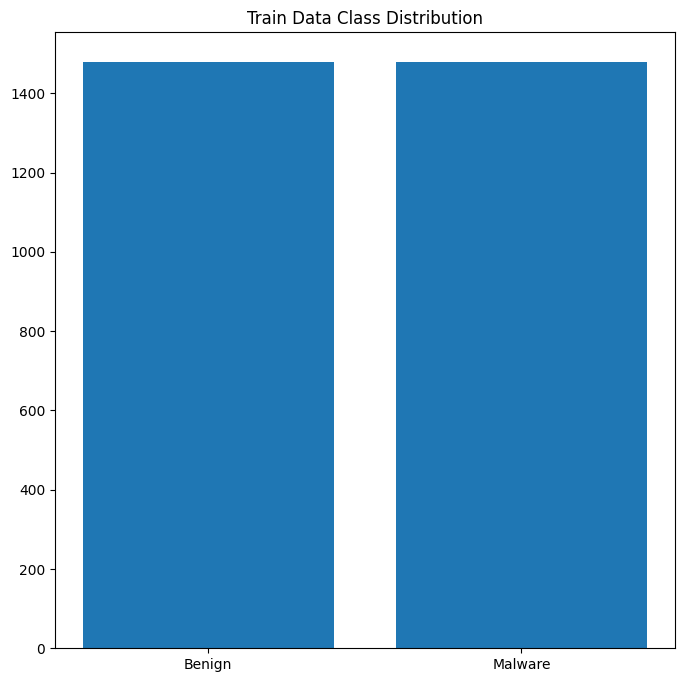

In [ ]:
# Plot the bar chart
plt.figure(figsize=(8, 8))
plt.bar(binary_list, class_counts)
plt.title('Train Data Class Distribution')
plt.show()

###test_data에 대한 클래스별 데이터 분포(pi graph)

In [ ]:
# Count the number of samples for each class in test_data
class_counts = [0] * len(binary_list)

for idx in range(len(test_data)):
  image, label, path, malware_type = test_data[idx]
  for i, mt in enumerate(classes):
    if mt == malware_type:
      class_counts[i] += 1

for i, mt in enumerate(classes):
  print(mt + " : " + str(class_counts[i]))

Malware : 176
Benign : 174


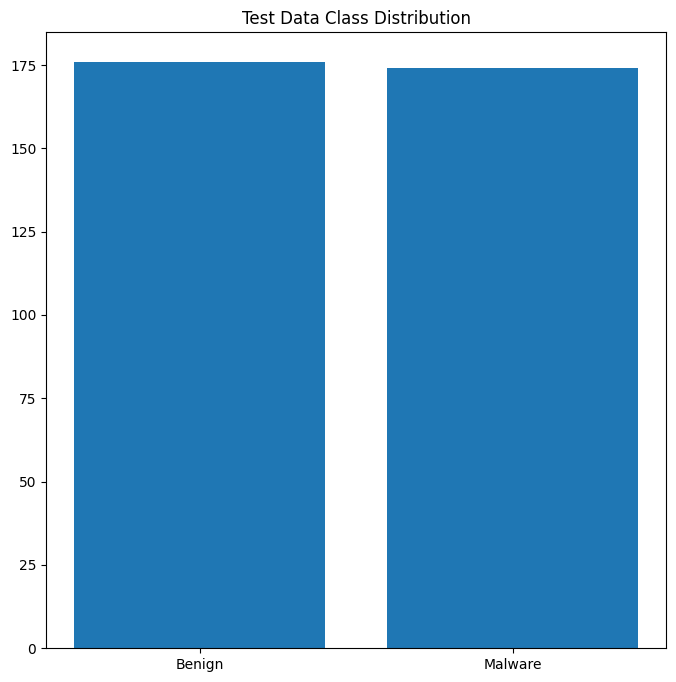

In [ ]:
# Plot the bar chart
plt.figure(figsize=(8, 8))
plt.bar(binary_list, class_counts)
plt.title('Test Data Class Distribution')
plt.show()

### 모델 불러오기

In [ ]:
from sklearn.manifold import TSNE # sklearn 사용하면 easy !!
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

시각화에 사용할 모델 불러오기

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 2) # fc를 nn.Linear(num_ftrs, 11)로 대체, CIFAR10,,
model = model.to(device)

In [ ]:
# classifier 들어가기 직전에 값을 뽑아낼 것임
# (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
print(model)

###T-SNE

#### Train T-SNE

In [ ]:
actual = []
deep_features = []

# Define a color map for each class
color_map = plt.cm.get_cmap('tab10', len(binary_list))

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

<ipython-input-80-4ae3e27ee051>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(binary_list))


In [ ]:
malware_list = {'Malware' : 1, 'Benign' : 0}

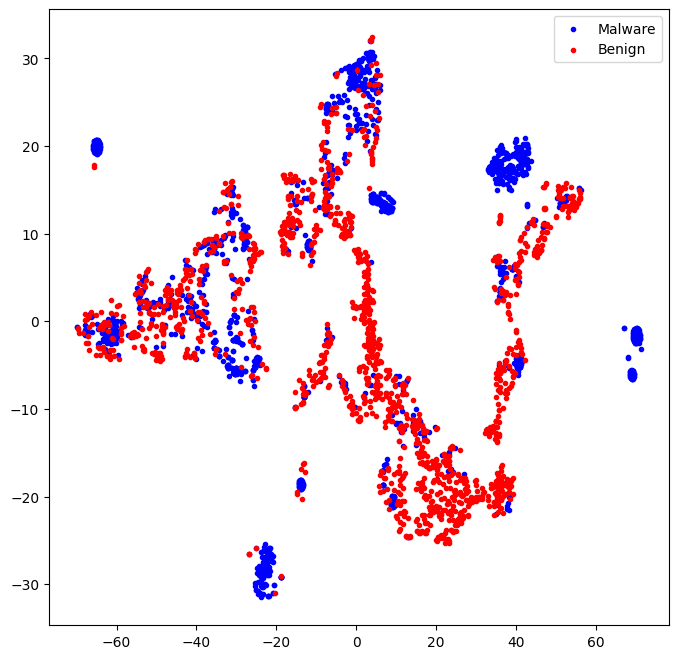

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=55, metric='manhattan')
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(8, 8))

def color_map(index):
    # Define your color map logic here
    colors = ['red', 'blue']  # Example color map
    return colors[index]

for label, malware_type in malware_list.items():
    malware_type_arr = np.array([malware_type] * len(actual))  # Convert malware_type to a NumPy array
    idx = np.where(actual == malware_type_arr)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, color=color_map(malware_type))

plt.legend()
plt.show()


#### Test T-SNE

In [ ]:
actual = []
deep_features = []

# Define a color map for each class
color_map = plt.cm.get_cmap('tab10', len(malware_list))

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

<ipython-input-87-38feaed4d7f6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(malware_list))


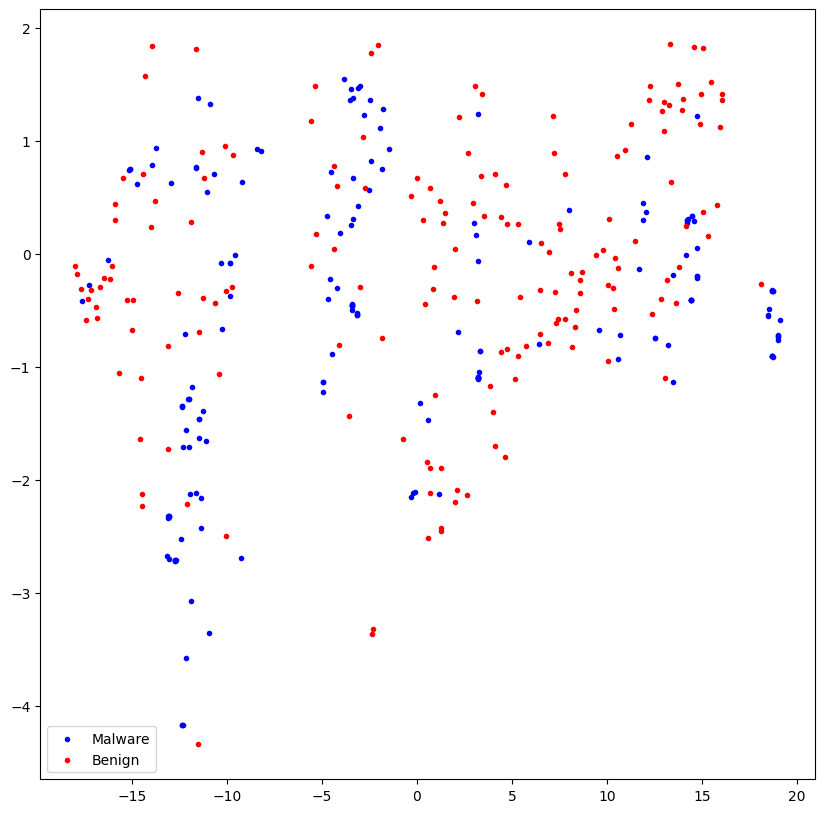

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=55, metric='manhattan')
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))

def color_map(index):
    # Define your color map logic here
    colors = ['red', 'blue']  # Example color map
    return colors[index]

for label, malware_type in malware_list.items():
    malware_type_arr = np.array([malware_type] * len(actual))  # Convert malware_type to a NumPy array
    idx = np.where(actual == malware_type_arr)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, color=color_map(malware_type))

plt.legend()
plt.show()

## 모델 구성

## Machine Learning

with GIST

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier


In [ ]:
# 데이터와 레이블 설정
X = descriptors

# 레이블 기록
labels_dict = classes
train_dir = "Train/"  # 이 경로에 train 데이터가 저장
val_dir = "Validation/"  # 이 경로에 test 데이터가 저장

# GIST_descriptors 및 레이블 불러오기
X_train = X
X_test = get_gist_descriptors(val_dir)

# 레이블 설정
labels_dict = classes

# 각 이미지에 맞는 레이블 생성
def load_labels(dir):
    y = []
    for subdir in sorted(os.listdir(dir)):
        subdir_path = os.path.join(dir, subdir)
        if os.path.isdir(subdir_path):
            for i, filename in enumerate(sorted(os.listdir(subdir_path))):
                y.append(labels_dict[subdir])
    return np.array(y)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Linear SVM': LinearSVC(),
    'SMO': SVC(kernel='rbf'), # SMO는 일반적으로 서포트 벡터 머신 (SVM)이 rbf 커널을 사용
    'J48': DecisionTreeClassifier() # J48는 scikit-learn에서 Decision Tree에 해당
}

# 성능 지표
scores = {'accuracy': accuracy_score, 'FPR': confusion_matrix, 'precision': precision_score, 'recall': recall_score, 'f1score': f1_score}

# 각 모델에 대해 교차 검증 및 테스트 세트에서 성능 평가
for model_name, model_instance in models.items():
    print(model_name)
    model_instance.fit(X_train_scaled, y_train)
    y_pred = model_instance.predict(X_test_scaled)
    for score_name, score_func in scores.items():
        if score_name == 'FPR':
            cm = score_func(y_test, y_pred)
            fp = cm.sum(axis=0) - np.diag(cm)
            tn = cm.sum() - (cm.sum(axis=1) + fp)
            fpr = np.mean(fp / (fp + tn))
            print(score_name, fpr)
        elif score_name == 'accuracy':
            print(score_name, score_func(y_test, y_pred))
        else:
            print(score_name, score_func(y_test, y_pred, average='weighted'))


with GIST+HOG

In [ ]:
hog_gist_concatenated = np.concatenate((HOG_descriptors, GIST_descriptors), axis=1)
hog_gist_concatenated.shape

In [ ]:

# 데이터와 레이블 설정
X = hog_gist_concatenated

# 레이블 기록
labels_dict = classes
train_dir = "Train/"  # 이 경로에 train 데이터가 저장
val_dir = "Validation/"  # 이 경로에 test 데이터가 저장

# GIST_descriptors 및 레이블 불러오기
X_train = X
X_test = get_gist_descriptors(val_dir)

# 레이블 설정
labels_dict = classes

# 각 이미지에 맞는 레이블 생성
def load_labels(dir):
    y = []
    for subdir in sorted(os.listdir(dir)):
        subdir_path = os.path.join(dir, subdir)
        if os.path.isdir(subdir_path):
            for i, filename in enumerate(sorted(os.listdir(subdir_path))):
                y.append(labels_dict[subdir])
    return np.array(y)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Length of X:", len(X))
print("Length of y:", len(y))

# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Linear SVM': LinearSVC(),
    'SMO': SVC(kernel='rbf'), # SMO는 일반적으로 서포트 벡터 머신 (SVM)이 rbf 커널을 사용
    'J48': DecisionTreeClassifier() # J48는 scikit-learn에서 Decision Tree에 해당
}

# 성능 지표
scores = {'accuracy': accuracy_score, 'FPR': confusion_matrix, 'precision': precision_score, 'recall': recall_score, 'f1score': f1_score}

# 각 모델에 대해 교차 검증 및 테스트 세트에서 성능 평가
for model_name, model_instance in models.items():
    print(model_name)
    model_instance.fit(X_train_scaled, y_train)
    y_pred = model_instance.predict(X_test_scaled)
    for score_name, score_func in scores.items():
        if score_name == 'FPR':
            cm = score_func(y_test, y_pred)
            fp = cm.sum(axis=0) - np.diag(cm)
            tn = cm.sum() - (cm.sum(axis=1) + fp)
            fpr = np.mean(fp / (fp + tn))
            print(score_name, fpr)
        elif score_name == 'accuracy':
            print(score_name, score_func(y_test, y_pred))
        else:
            print(score_name, score_func(y_test, y_pred, average='weighted'))


## Deep Learning

In [ ]:
# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model List

#### Model-DNN

In [ ]:
# DNN 모델 클래스 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(224 * 224 * 3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 입력 이미지를 1차원
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN().to(device)

#### Model-CNN basic

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3) # in_channel, out_channel, kernel size
        self.pool = nn.MaxPool2d(3, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(56180, 160) # in_features, out_features
        self.fc2 = nn.Linear(160, 120)
        self.fc3 = nn.Linear(120, 2)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = CNN().to(device)

#### Model-ResNet50

In [ ]:
class Refined_ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super(Refined_ResNet, self).__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_model_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_model_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_model_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_model_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_model_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [ ]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

##### model_info

In [ ]:
Model_Info = namedtuple('Model_Info', ['block', 'n_blocks', 'channels'])

Model_config = Model_Info(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [ ]:
pretrained_model = models.resnet50(pretrained = True)

for param in pretrained_model.parameters():
    param.requires_grad = False

# Fine Tuning
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = 2

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model = Refined_ResNet(Model_config, OUTPUT_DIM).to(device)

In [ ]:

# Model Load
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


### LR_finder

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
# Model Summary
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th = 5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels, _, _ = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, _, _ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 30):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

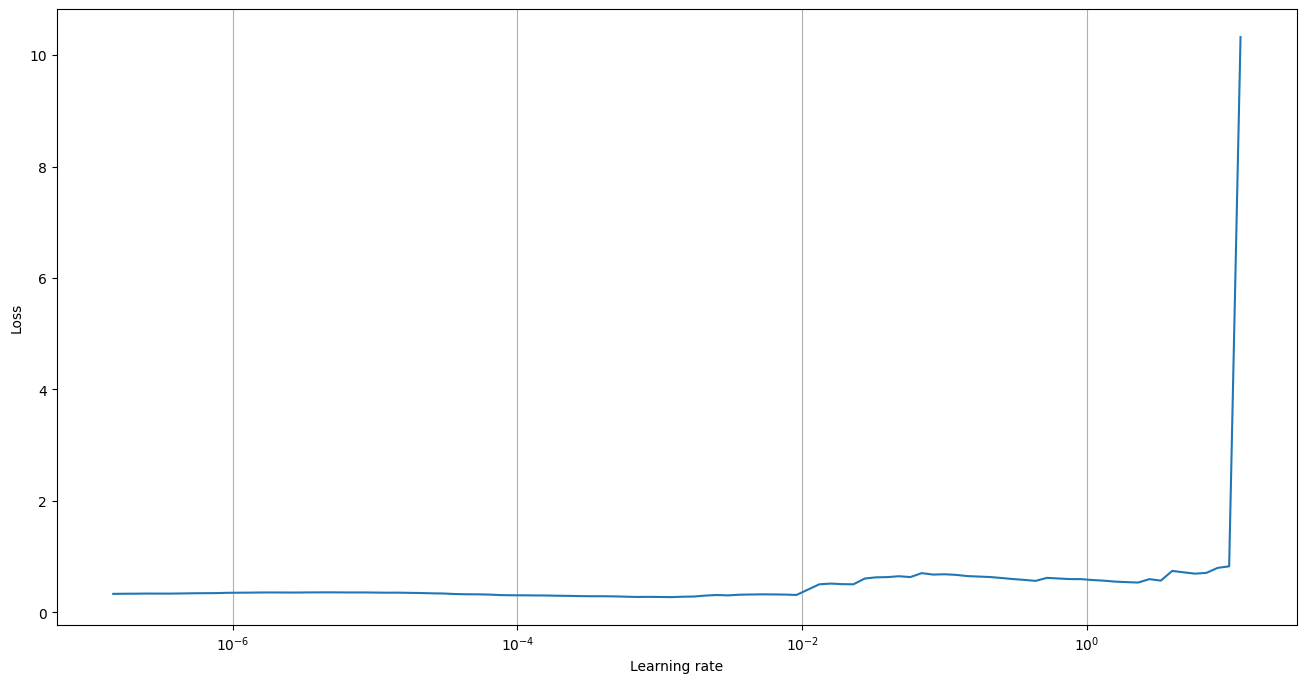

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0)

In [ ]:
FOUND_LR = 1e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='.init_params.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: '.init_params.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 모델 학습

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y, _, _) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc = (y_pred.argmax(dim=1) == y).float().mean()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)

    return epoch_loss, epoch_acc

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y, _, _) in iterator:

           x = x.to(device)
           y = y.to(device)

           y_pred = model(x)

           loss = criterion(y_pred, y)
           acc = (y_pred.argmax(dim=1) == y).float().mean()

           epoch_loss += loss.item()
           epoch_acc += acc.item()

    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)

    return epoch_loss, epoch_acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
result_list = []
lr_list = []

patience = 5

early_stopping = EarlyStopping(patience = patience, verbose = True)

for epoch in range(100):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

    early_stopping(valid_loss, model)
    lr_list.append(optimizer.param_groups[0]["lr"])

    # patience 동안 val_loss가 감소하지 않으면 조기 종료
    if early_stopping.early_stop:
      print("Early stopping")
      break

    # val_loss 감소하면 best model 불러오기
    model.load_state_dict(torch.load('./init_params.pt'))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')

    result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train acc': train_acc,
    'Valid Loss': valid_loss,
    'Valid acc': valid_acc}

    result_list.append(result)

Validation loss decreased (inf --> 0.292833).  Saving model ...
Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.512 | Train Acc:  74.93%
	Valid Loss: 0.293 | Valid Acc:  87.78%
EarlyStopping counter: 1 out of 5
Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 0.521 | Train Acc:  72.88%
	Valid Loss: 0.305 | Valid Acc:  88.83%
Validation loss decreased (0.292833 --> 0.277059).  Saving model ...
Epoch: 03 | Epoch Time: 0m 50s
	Train Loss: 0.523 | Train Acc:  73.89%
	Valid Loss: 0.277 | Valid Acc:  91.76%
EarlyStopping counter: 1 out of 5
Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 0.524 | Train Acc:  74.76%
	Valid Loss: 0.374 | Valid Acc:  86.36%
EarlyStopping counter: 2 out of 5
Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 0.504 | Train Acc:  74.66%
	Valid Loss: 0.424 | Valid Acc:  81.53%
Validation loss decreased (0.277059 --> 0.235403).  Saving model ...
Epoch: 06 | Epoch Time: 0m 51s
	Train Loss: 0.496 | Train Acc:  74.76%
	Valid Loss: 0.235 | Valid Acc:  89.20%
EarlyStopping counter: 1 out o

KeyboardInterrupt: ignored

## 모델 평가

In [ ]:
result_df = pd.DataFrame(result_list)

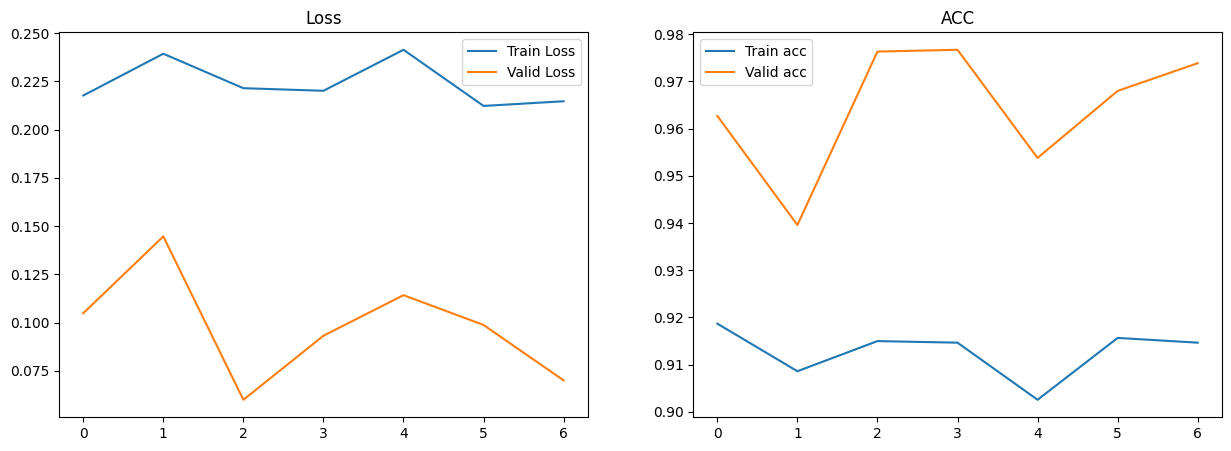

In [ ]:
# Loss 및 Acc 변화 그래프
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Valid Loss'], label='Valid Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train acc'], label='Train acc')
axes[1].plot(result_df['EPOCH'], result_df['Valid acc'], label='Valid acc')
axes[1].legend()
axes[1].set_title('ACC')


plt.show()

Text(0, 0.5, 'Learning Rate')

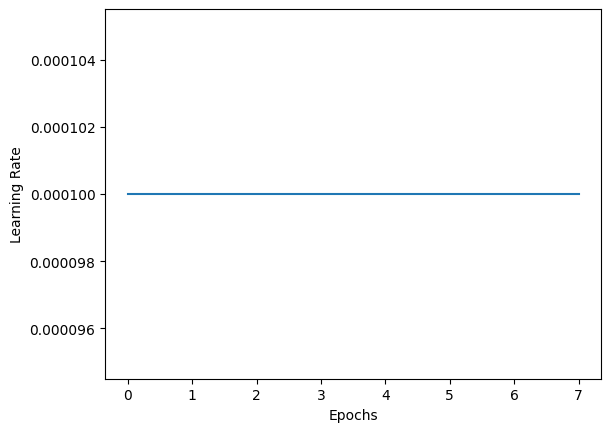

In [ ]:
plt.plot(lr_list)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

In [ ]:
model.load_state_dict(torch.load('.init_params.pt'))

<All keys matched successfully>

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc*100:6.2f}%')

Test Loss: 0.089 | Test Acc @1:  97.14%


In [ ]:
# 각 항목별 정확도 및 컨퓨전 매트릭스
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for idx, (inputs, classes, _, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9770, 0.9659])


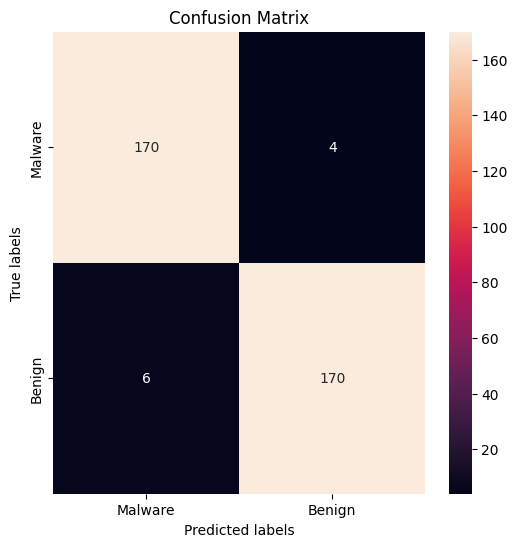

In [ ]:
# 컨퓨전 매트릭스 heatmap 그리기

binary_list = ['Malware', 'Benign']
plt.figure(figsize=(6, 6))
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(binary_list); ax.yaxis.set_ticklabels(binary_list);

In [ ]:
actual = []
deep_features = []

# Define a color map for each class
color_map = plt.cm.get_cmap('tab10', len(binary_list))

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

<ipython-input-57-4ae3e27ee051>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(binary_list))


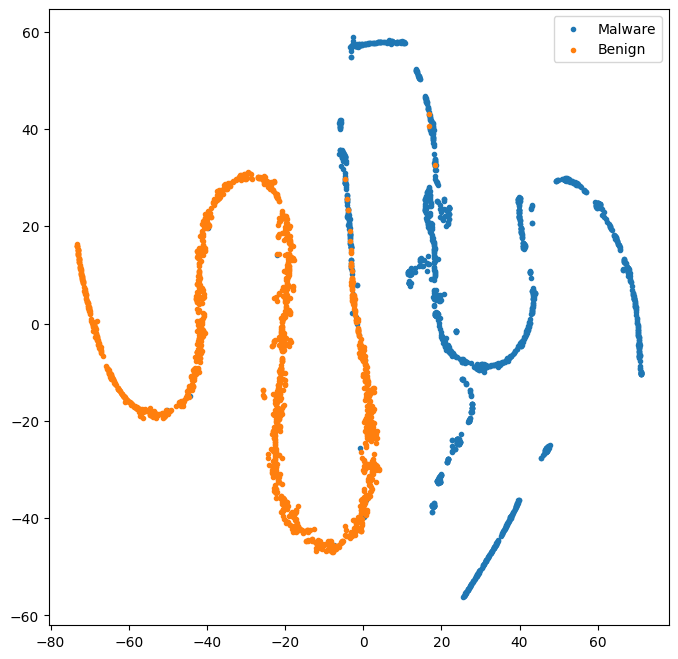

In [ ]:
malware_list = {'Malware' : 1, 'Benign' : 0}

tsne = TSNE(n_components=2, metric='manhattan')
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(8, 8))


for label, malware_type in malware_list.items():
    malware_type_arr = np.array([malware_type] * len(actual))  # Convert malware_type to a NumPy array
    idx = np.where(actual == malware_type_arr)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

## 결과 분석-히트맵

In [ ]:
import cv2

# 이미지를 히트맵으로 시각화하는 함수
def visualize_heatmap(image_path, model, target_layer, ax):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 이미지 전처리
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    # 입력 텐서와 모델의 가중치를 동일한 디바이스에 위치시키기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    model.to(device)

    # 모델의 특징 맵 추출하기
    model.eval()
    features = []
    def hook_fn(module, input, output):
        features.append(output.data.cpu().numpy())
    hook = target_layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        _ = model(input_batch)
    hook.remove()

    # 히트맵 생성하기
    heatmap = torch.mean(torch.tensor(features[0]), dim=1).squeeze()
    heatmap = nn.functional.relu(heatmap)
    heatmap /= torch.max(heatmap)

    # 히트맵을 원본 이미지에 적용하기
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 히트맵을 겹쳐서 시각화하기
    superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    # 이미지 출력
    ax.imshow(superimposed_img)
    ax.axis('off')

target_layer = model.layer4[-1]


In [ ]:
misclassified_images = []
misclassified_labels = []
misclassified_indices = []
misclassified_file_paths = []

model.eval()
with torch.no_grad():
    for images, labels, file_paths, _ in test_loader:  # 테스트 로더에서 파일 경로를 제공하는 것으로 가정합니다
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        misclassified_idx = (predicted != labels).nonzero()

        misclassified_images.extend(images[misclassified_idx])
        misclassified_labels.extend(predicted[misclassified_idx])
        misclassified_indices.extend(misclassified_idx)

        for idx in range(len(misclassified_idx.view(-1))):
          misclassified_file_paths.append(file_paths[misclassified_idx.view(-1)[idx]])



In [ ]:
binary = {0 : 'Benign', 1 : 'Malware'}

In [ ]:
import re

def extract_string_between(path):
    pattern = r'Test/(.*?)/'
    match = re.search(pattern, path)
    if match:
        extracted_string = match.group(1)
        return extracted_string
    else:
        return None

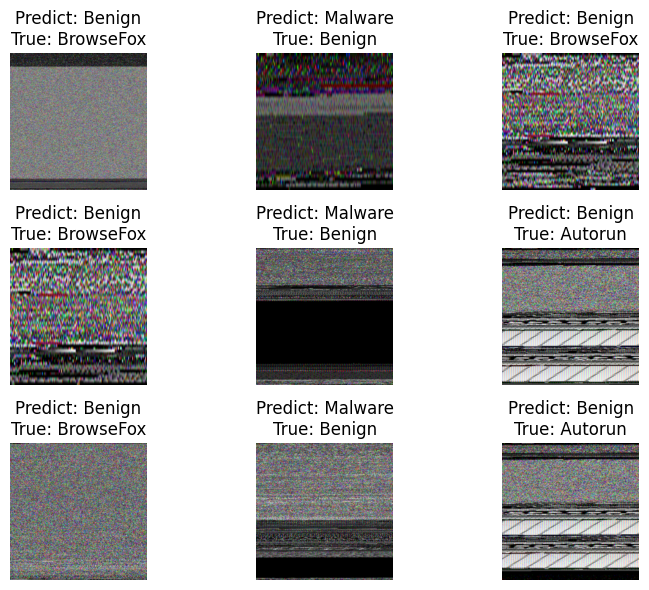

In [ ]:
# 잘못 예측한 데이터 개수 확인
misclassified_count = len(misclassified_images)

# 잘못 예측한 데이터 시각화 및 히트맵 생성
num_images = min(9, misclassified_count)
fig, axes = plt.subplots(int(num_images/3), 3, figsize=(8, 6))

for i, ax in enumerate(axes.flatten()):
    if i < misclassified_count:
        image = misclassified_images[i].cpu().numpy()
        file_path = misclassified_file_paths[i]

        # 이미지 차원 순서 확인 및 수정
        if image.shape[0] == 1:  # 흑백 이미지인 경우
            image = np.squeeze(image, axis=0)  # 채널 차원 제거
        else:  # 컬러 이미지인 경우
            image = image.transpose((1, 2, 0))

        label = misclassified_labels[i].item()
        index = misclassified_indices[i].item()

        image = np.transpose(image, (1, 2, 0))

        ax.imshow(image)
        ax.set_title(f"Predict: {'Benign' if label == 0 else 'Malware'}\nTrue: {extract_string_between(file_path)}")
        ax.axis('off')


plt.tight_layout()
plt.show()

IndexError: ignored

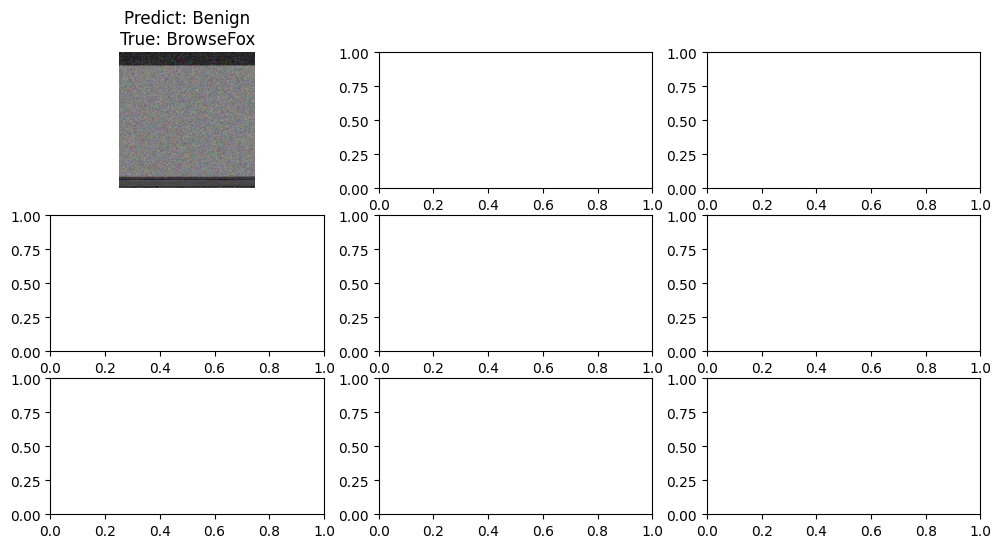

In [ ]:
# 잘못 예측한 데이터 개수 확인
misclassified_count = len(misclassified_images)

# 잘못 예측한 데이터 시각화 및 히트맵 생성
num_images = min(9, misclassified_count)
fig, axes = plt.subplots(int(num_images/3), 3, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < misclassified_count:
        file_path = misclassified_file_paths[i]

        ax.imshow(plt.imread(file_path))
        ax.set_title(f"Predict: {'Benign' if label == 0 else 'Malware'}\nTrue: {extract_string_between(file_path)}")
        ax.axis('off')

        # 히트맵 생성
        visualize_heatmap(file_path, model, target_layer, ax)


plt.tight_layout()
plt.show()


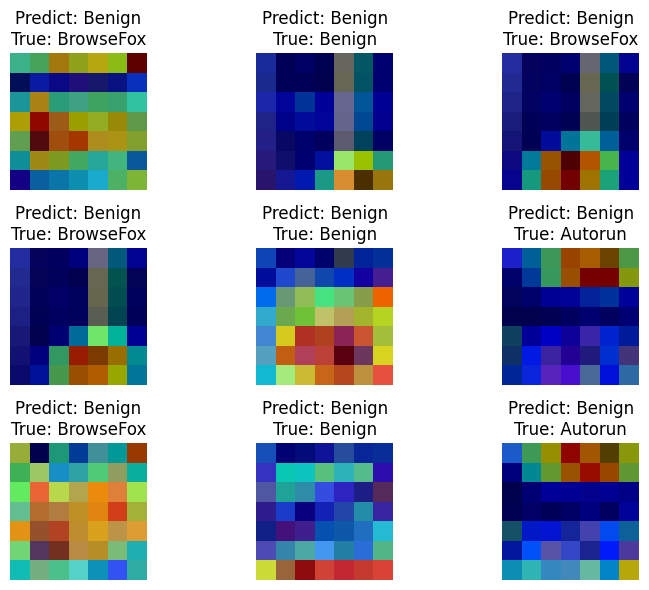

In [ ]:
num_images = min(9, misclassified_count)
fig, axes = plt.subplots(int(num_images/3), 3, figsize=(8, 6))

for i, ax in enumerate(axes.flatten()):
    if i < misclassified_count:
        file_path = misclassified_file_paths[i]

        # 이미지 불러오기 및 전처리
        image = Image.open(file_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        # 입력 텐서와 모델의 가중치를 동일한 디바이스에 위치시키기
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_batch = input_batch.to(device)
        model.to(device)

        # 모델의 특징 맵 추출하기
        model.eval()
        features = []
        def hook_fn(module, input, output):
            features.append(output.data.cpu().numpy())
        hook = target_layer.register_forward_hook(hook_fn)
        with torch.no_grad():
            _ = model(input_batch)
        hook.remove()

        # 히트맵 생성하기
        heatmap = torch.mean(torch.tensor(features[0]), dim=1).squeeze()
        heatmap = nn.functional.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # 원본 이미지와 히트맵을 겹쳐서 시각화하기
        ax.imshow(image)
        ax.set_title(f"Predict: {'Benign' if label == 0 else 'Malware'}\nTrue: {extract_string_between(file_path)}")
        ax.imshow(heatmap, alpha=0.6, cmap='jet')
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Move the model to the desired device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modify the linear layer to have a single output neuron
model.fc = nn.Linear(2048, 2)

# Create empty dictionaries to store class features and counts
class_features = {0: [], 1: []}
class_counts = {0: 0, 1: 0}

# Set the model to evaluation mode
model.eval()

# Iterate over the train_loader to extract class features
with torch.no_grad():
    for images, labels, _, _ in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        features = model(images)

        # Update class features and counts
        for feature, label in zip(features, labels):
            class_features[label.item()].append(feature)
            class_counts[label.item()] += 1

# Calculate average features for each class
class_avg_features = {}
for label, features in class_features.items():
    avg_features = torch.stack(features).mean(dim=0)
    class_avg_features[label] = avg_features

# Normalize and visualize the heatmaps
for label, avg_features in class_avg_features.items():
    heatmap = nn.functional.relu(avg_features)
    heatmap /= torch.max(heatmap)

    # Visualize the heatmap
    plt.imshow(heatmap.squeeze().cpu(), cmap='jet')
    plt.title(f'Class {label} Heatmap')
    plt.axis('off')
    plt.show()


RuntimeError: ignored